<span style="font-size:large;">
<div style="text-align: right">IM-UH 1511 <b>Introduction to Digital Humanities</b><br/>
Student name: <span style="color:blue"><b>X XX</b></span><br/>
Grade: <span style="color:red"><b></b></span><br/><br/></div>

## <span style="color:red">HOMEWORK 3</span>
# <span style="color:green">Unsupervized and Supervised Topic Modeling

### <span style="color:blue">This notebook is composed of four parts (PART A, B, C, and D). 
### <span style="color:blue">You are advised to run each Part separately until you get a satisfacory outpout from that part 
### <span style="color:blue">and only subsequently you may proceed to the next Part.</span>

## <span style="color:red">PART A</span>

In [1]:
import time
start_time = time.perf_counter()
import urllib, os, codecs, random, operator, re, string, copy, dateutil.parser, itertools, pickle, datetime, math, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from collections import Counter
from string import punctuation, digits
import pathlib
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')
import inflect
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from nltk.stem.porter import *
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.corpora import Dictionary
import pyLDAvis
from pyLDAvis import gensim as pgensim
pyLDAvis.enable_notebook()

def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.simplefilter('ignore')

### Load Data

In [2]:
titlename = "Bram Stoker's Dracula"

# get your working directory
home = str(pathlib.Path.cwd())

# create a path to which the file will be written
text_path = os.path.join(home, 'Dracula.txt')

# location of the project gutenberg copy of the moby-dick text file
text_url = 'http://www.gutenberg.org/cache/epub/345/pg345.txt'

urllib.request.urlretrieve(text_url, text_path)

print('Downloaded to:', text_path)

Downloaded to: /Users/moses/WorkPlaces/Python Projects 2/3 NYUAD Digital Humanities/Homework3 TopicModeling & Co-OccurrentTermNets/Dracula.txt


In [3]:
f = codecs.open(text_path, "r", encoding="utf-8").readlines()
for line in f:
    if line.startswith("(_Kept in shorthand._)"):
        print(f.index(line)) #198
    if line.startswith("                                THE END"):
        print(f.index(line)) #15514

198
15514


In [4]:
ff=f[194:15513]
ff

['CHAPTER I\r\n',
 '\r\n',
 "JONATHAN HARKER'S JOURNAL\r\n",
 '\r\n',
 '(_Kept in shorthand._)\r\n',
 '\r\n',
 '\r\n',
 '_3 May. Bistritz._--Left Munich at 8:35 P. M., on 1st May, arriving at\r\n',
 'Vienna early next morning; should have arrived at 6:46, but train was an\r\n',
 'hour late. Buda-Pesth seems a wonderful place, from the glimpse which I\r\n',
 'got of it from the train and the little I could walk through the\r\n',
 'streets. I feared to go very far from the station, as we had arrived\r\n',
 'late and would start as near the correct time as possible. The\r\n',
 'impression I had was that we were leaving the West and entering the\r\n',
 'East; the most western of splendid bridges over the Danube, which is\r\n',
 'here of noble width and depth, took us among the traditions of Turkish\r\n',
 'rule.\r\n',
 '\r\n',
 'We left in pretty good time, and came after nightfall to Klausenburgh.\r\n',
 'Here I stopped for the night at the Hotel Royale. I had for dinner, or\r\n',
 'rathe

In [5]:
ff[-10:]

['We could hardly ask any one, even did we wish to, to accept these as\r\n',
 'proofs of so wild a story. Van Helsing summed it all up as he said, with\r\n',
 'our boy on his knee:--\r\n',
 '\r\n',
 '"We want no proofs; we ask none to believe us! This boy will some day\r\n',
 'know what a brave and gallant woman his mother is. Already he knows her\r\n',
 'sweetness and loving care; later on he will understand how some men so\r\n',
 'loved her, that they did dare much for her sake."\r\n',
 '\r\n',
 'JONATHAN HARKER.\r\n']

### Breaking in Chapters

In [6]:
text=[]
text="\n".join(ff).split("CHAPTER")[1:]
print(type(text),len(text))
# print(text[0])
docs_d={}
for i,j in enumerate(text):
#     docs_d["Chapter"+str(i+1)]="CHAPTER "+j.replace("\n\n\n\n"," ").replace("\n\n\n"," ").replace("\n\n"," ").replace("\n"," ")
    docs_d["Chapter"+str(i+1)]=j.lstrip().replace("\r","").replace("\n\n\n\n\n\n"," ").replace("\n\n\n\n\n"," ").replace("\n\n\n\n"," ").replace("\n\n\n"," ").replace("\n\n"," ").replace("\n"," ").replace("_","").replace("--","")
print(len(docs_d))
docs=list(docs_d.values())
print(len(docs))
chapter=8
print("This is the beginning of the %i-th document (%i-th chapter):"%(chapter+1,chapter+1))
list(docs)[chapter][:1000]

<class 'list'> 27
27
27
This is the beginning of the 9-th document (9-th chapter):


'IX Letter, Mina Harker to Lucy Westenra. "Buda-Pesth, 24 August. "My dearest Lucy, "I know you will be anxious to hear all that has happened since we parted at the railway station at Whitby. Well, my dear, I got to Hull all right, and caught the boat to Hamburg, and then the train on here. I feel that I can hardly recall anything of the journey, except that I knew I was coming to Jonathan, and, that as I should have to do some nursing, I had better get all the sleep I could.... I found my dear one, oh, so thin and pale and weak-looking. All the resolution has gone out of his dear eyes, and that quiet dignity which I told you was in his face has vanished. He is only a wreck of himself, and he does not remember anything that has happened to him for a long time past. At least, he wants me to believe so, and I shall never ask. He has had some terrible shock, and I fear it might tax his poor brain if he were to try to recall it. Sister Agatha, who is a good creature and a born nurse, tells

## 1. Unsupervized Topic Modeling

In [7]:
sorted(stopwords.words('english'))

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [8]:
stop_words = stopwords.words('english') #+ list(punctuation) 

def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]  

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [9]:
vocabulary = set()
for i in docs:
    words = tokenize(i)
    vocabulary.update(words)
 
vocabulary = list(vocabulary)
word_index = {w: idx for idx, w in enumerate(vocabulary)}
 
VOCABULARY_SIZE = len(vocabulary)
DOCUMENTS_COUNT = len(docs)
 
print(VOCABULARY_SIZE, DOCUMENTS_COUNT)

10274 27


In [10]:
excl=[u'ere',u'ye',u'wouldn',u'madam',u'happened']
# processed_docs = ppdocs #[preprocess(doc) for doc in documents]
processed_docs = [preprocess(doc) for doc in docs]
processed_docs1=[]
for x in processed_docs:
    y=[]
    for xx in x:
        if xx not in excl:
            y.append(xx)
    processed_docs1.append(y)
processed_docs=processed_docs1
allw=[]
for x in processed_docs:
    for xx in x:
        if xx not in allw:
            allw.append(xx)
print(len(allw)) #All 5752
# processed_docs[:10]

6326


In [11]:
allws=[]
for z in processed_docs:
    for zz in z:
        allws.append(zz)
print(len(allws),len(set(allws)))
# sorted(allws)
allwd=Counter(allws)
print(len(allwd))
# for p,q in allwd.items():
#     print(p,q)
# count = 0
# for k in sorted(allwd.keys()):
#     print(k)
#     count += 1
#     if count > 50:
#         break

54368 6326
6326


In [12]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print(len(dictionary)) #All 32368
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

6326
0 abl
1 abreast
2 absenc
3 accustom
4 add
5 affect
6 afield
7 afraid
8 afternoon
9 agonis
10 ahead


In [13]:
dictionary.filter_extremes(no_below=5) #, no_above=0.8) #, keep_n=300) # 5
len(dictionary) 

1004

In [14]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
# bow_corpus[43]

#### Detecting "Optimal" Number of Topics

#### <span style="color:red">The minimum number of topics below (mint) should be at least 2 or 3.</span>

In [15]:
mint = 3  # minimum number of topics
maxt = 11 # maximum number of topics
m=30
X = range(mint,maxt)
Y = []
for n in X:
    ft=[]
    for j in range(m):
        lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n, id2word=dictionary, passes=2, workers=2)
    #     topics = lda_model.print_topics()
        sss=[]
        for idx, topic in lda_model.print_topics(-1):
            tt=[]
            s=topic.split(" + ")
            ss=[]
            uu=[]
            for t in s:
                u0=float(t.split("*")[0])
                u1=t.split("*")[1].replace('"','')
                if (u1,u0) not in ss:
                    ss.append((u1,u0))
                if t not in uu:
                    uu.append(t) 
            sss.append(ss)
            topic=" + ".join(uu).encode('utf-8')
        doms=[]
        for i in sss:
            doms.append(i[0][0])
        fi=len(set(doms))/n
        ft.append(fi)
    fis=sum(ft)/m
    Y.append(fis)
# print(list(X))
print(Y)
nn=[]
for i,y in enumerate(Y):
    if y==max(Y): #1:
        print(Y.index(y))
        nn.append(i)
print(nn)
NT=nn[-1]+mint
print(NT)

[0.9777777777777777, 0.9416666666666667, 0.98, 0.8833333333333332, 0.8571428571428572, 0.85, 0.8444444444444447, 0.7899999999999999]
2
[2]
5


In [16]:
nt=NT #number_of_topics
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=nt, id2word=dictionary, passes=2, workers=2)

In [17]:
topics = lda_model.print_topics() #350  #num_words=25

terms=[]
lt=[]
for i in range(nt):
    for t in topics: 
        lt.append(t[1].split(" + "))
for s in lt:
    for ss in s:
        terms.append(ss[6:])
#         if re.sub(r'[^a-zA-Z]','', ss) not in terms:
#             terms.append(re.sub(r'[^a-zA-Z]','', ss))
terms=[t.replace('"',"") for t in terms]
terms=sorted(set(terms))
print(len(terms))
print(" ")
print("LIST OF UNSUPERVISED TM TERMS:")
print(" ")
for i in terms:
    print(i)

32
 
LIST OF UNSUPERVISED TM TERMS:
 
box
castl
clue
coffin
destroy
dracula
east
flame
forward
free
hall
hors
lunch
monster
mother
octob
renfield
report
river
seat
septemb
ship
snow
sunris
sweep
telegram
tomb
varna
weak
westenra
wolf
wolv


In [18]:
sss=[]
for idx, topic in lda_model.print_topics(-1):
    tt=[]
    s=topic.split(" + ")
    ss=[]
    uu=[]
    for t in s:
        u0=float(t.split("*")[0])
        u1=t.split("*")[1].replace('"','')
        if (u1,u0) not in ss:
            ss.append((u1,u0))
        if t not in uu:
            uu.append(t) 
    sss.append(ss)
    topic=" + ".join(uu).encode('utf-8')
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: b'0.009*"septemb" + 0.008*"westenra" + 0.006*"renfield" + 0.005*"ship" + 0.005*"box" + 0.004*"weak" + 0.004*"mother" + 0.004*"clue" + 0.004*"lunch" + 0.004*"hors"'
Topic: 1 
Words: b'0.006*"mother" + 0.006*"box" + 0.006*"ship" + 0.005*"wolf" + 0.005*"seat" + 0.005*"report" + 0.004*"hall" + 0.004*"snow" + 0.004*"octob" + 0.004*"east"'
Topic: 2 
Words: b'0.006*"coffin" + 0.005*"septemb" + 0.005*"box" + 0.005*"renfield" + 0.004*"tomb" + 0.004*"forward" + 0.004*"weak" + 0.004*"monster" + 0.004*"hall" + 0.004*"destroy"'
Topic: 3 
Words: b'0.009*"hors" + 0.007*"castl" + 0.006*"ship" + 0.006*"sweep" + 0.006*"snow" + 0.005*"wolv" + 0.005*"river" + 0.005*"seat" + 0.005*"dracula" + 0.004*"flame"'
Topic: 4 
Words: b'0.009*"ship" + 0.008*"report" + 0.007*"octob" + 0.005*"tomb" + 0.005*"telegram" + 0.005*"coffin" + 0.005*"free" + 0.005*"sunris" + 0.004*"septemb" + 0.004*"varna"'


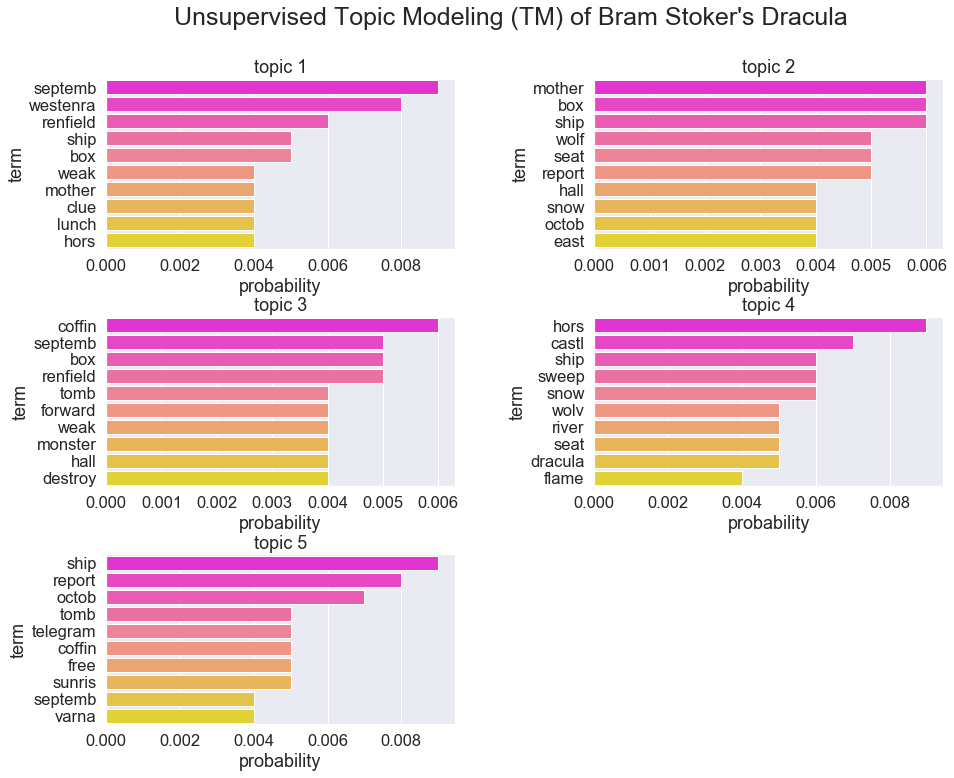

In [19]:
fig=plt.figure(figsize=(15,25)) #figsize=(15,2.4*15*((nt+1)/4))); #15
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(nt):
    sns.set(font_scale = 1.5)
    df=pd.DataFrame(sss[i], columns=['term','prob']).set_index('term')
#     plt.subplot(nt+1,2,i+1); #5
    ax = fig.add_subplot(nt+1,2,i+1)
    plt.title('topic '+str(i+1));
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='spring');
    plt.xlabel('probability');
sst="Unsupervised Topic Modeling (TM) of %s" %titlename
plt.suptitle(sst,fontsize=25, y=0.92);
plt.show()

In [20]:
from pyLDAvis import gensim as pgensim
vis = pgensim.prepare(lda_model,bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.038043 -0.006002       1        1  34.944347
2     -0.011333  0.028808       2        1  24.890829
0     -0.037145 -0.014932       3        1  22.160410
1      0.012177 -0.000973       4        1  15.211739
4     -0.001741 -0.006901       5        1   2.792678, topic_info=          Term       Freq      Total Category  logprob  loglift
586       ship  62.000000  62.000000  Default  30.0000  30.0000
806     report  21.000000  21.000000  Default  29.0000  29.0000
1002     octob  35.000000  35.000000  Default  28.0000  28.0000
747    septemb  55.000000  55.000000  Default  27.0000  27.0000
751   telegram  25.000000  25.000000  Default  26.0000  26.0000
...        ...        ...        ...      ...      ...      ...
610       warn   0.945179  26.082033   Topic5  -5.9058   0.2605
101      figur   0.972783  32.414822   Topic5  -5.8771   0.0720
525      escap   0.944422  30.215685   Topic5  -5.9066   0.1126
130       hors   1.034451  65.267990   Topic5  -5.8156  -0.5665
244       snow   0.946893  41.381016   Topic5  -5.9040  -0.1992

[314 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
697       1  0.151683  abroad
697       2  0.151683  abroad
697       3  0.455049  abroad
697       4  0.151683  abroad
615       1  0.179098  action
...     ...       ...     ...
868       4  0.437378   wrist
696       1  0.132780   youth
696       2  0.531122   youth
696       3  0.265561   youth
696       4  0.132780   youth

[971 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

## <span style="color:red">PART B</span>

## The Network of Sententially Co-Occurrent Terms Derived from Unsupervised Topic Modeling

In [21]:
terms

['box',
 'castl',
 'clue',
 'coffin',
 'destroy',
 'dracula',
 'east',
 'flame',
 'forward',
 'free',
 'hall',
 'hors',
 'lunch',
 'monster',
 'mother',
 'octob',
 'renfield',
 'report',
 'river',
 'seat',
 'septemb',
 'ship',
 'snow',
 'sunris',
 'sweep',
 'telegram',
 'tomb',
 'varna',
 'weak',
 'westenra',
 'wolf',
 'wolv']

In [22]:
pre=[]
for i in range(len(terms)):
    start=terms[i][:4]
    pre.append(start)
for j,k in Counter(pre).items():
    if k>1:
        print(j)

In [23]:
# # When no alias dictionary is needed

alias_dict={}
for n in terms:
    alias_dict[n]=n
    
# # For the case you need to use an alias dictionary:

# alias_dict={}
# for n in terms:
#     if n=="paper":
#         alias_dict[n]="paper"
#     elif n=="papers":
#         alias_dict[n]="paper"
#     elif n=="steps":
#         alias_dict[n]="steps"
#     elif n=="stepped":
#         alias_dict[n]="steps"
#     if n=="anxiety":
#         alias_dict[n]="anxiety"
#     elif n=="anxious":
#         alias_dict[n]="anxiety"
#     if n=="fall":
#         alias_dict[n]="fall"
#     elif n=="fallen":
#         alias_dict[n]="falling"
#     elif n=="falling":
#         alias_dict[n]="falling"
#     elif n=="laugh":
#         alias_dict[n]="laugh"
#     elif n=="laughed":
#         alias_dict[n]="laugh"
#     elif n=="spirit":
#         alias_dict[n]="spirit"
#     elif n=="spirits":
#         alias_dict[n]="spirit"
#     elif n=="tells":
#         alias_dict[n]="telling"
#     elif n=="telling":
#         alias_dict[n]="telling"
#     elif n=="wished":
#         alias_dict[n]="wishes"
#     elif n=="wishes":
#         alias_dict[n]="wishes"
#     else:
#         alias_dict[n]=n

print("The dictionary of aliases has %i keys (terms) and %i unique values (aliased terms)" %(len(alias_dict.keys()),len(set(alias_dict.values()))))
# for k,v in alias_dict.items():
#     print(k,"-->",v)

The dictionary of aliases has 32 keys (terms) and 32 unique values (aliased terms)


In [24]:
tdocs=" ".join(docs)
blob = TextBlob(tdocs)
textSentences = blob.sentences
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in list(set(alias_dict.values())):
        if term in v: 
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl 
medges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        if alias_dict[jj[0]]!=alias_dict[jj[1]]:
            medges.append((alias_dict[jj[0]],alias_dict[jj[1]],"Sentence_"+str(k),ss/float(s)))
print("%s contains %i sentential co-occurrences among %i unsupervized TM terms"%(titlename,len(medges),len(set(alias_dict.values()))))
medges

Bram Stoker's Dracula contains 207 sentential co-occurrences among 32 unsupervized TM terms


[('river', 'castl', 'Sentence_30', 0.13511904761904764),
 ('river', 'sweep', 'Sentence_31', 0.17777777777777778),
 ('river', 'seat', 'Sentence_95', 0.0),
 ('river', 'seat', 'Sentence_103', -0.0375),
 ('river', 'east', 'Sentence_103', -0.0375),
 ('box', 'river', 'Sentence_103', -0.0375),
 ('box', 'seat', 'Sentence_103', -0.0375),
 ('seat', 'hors', 'Sentence_103', -0.0375),
 ('box', 'hors', 'Sentence_103', -0.0375),
 ('river', 'hors', 'Sentence_103', -0.0375),
 ('hors', 'east', 'Sentence_103', -0.0375),
 ('seat', 'east', 'Sentence_103', -0.0375),
 ('box', 'east', 'Sentence_103', -0.0375),
 ('river', 'hors', 'Sentence_130', -0.15000000000000002),
 ('river', 'forward', 'Sentence_142', 0.0),
 ('river', 'hors', 'Sentence_156', 0.1),
 ('river', 'hors', 'Sentence_172', 0.0),
 ('river', 'hors', 'Sentence_186', 0.03148148148148147),
 ('wolv', 'hors', 'Sentence_187', 0.06875),
 ('river', 'hors', 'Sentence_187', 0.06875),
 ('river', 'wolv', 'Sentence_187', 0.06875),
 ('river', 'hors', 'Sentence_18

In [25]:
medgesd=[]
for e in medges:
    d={}
    d['Sentence']=e[2]
    d['Average sentiment']=e[3]
    medgesd.append((e[0],e[1],d))
    
G = nx.MultiGraph()
G.add_edges_from(medgesd)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
weight={(x,y):v for (x, y), v in Counter(G.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)

print("The graph of sententially co-occurrent unsupervised TM terms in %s is a weighted graph and \n it has %i nodes and %i edges \n" %(titlename,len(Gw.nodes()),len(Gw.edges())))
out=' '.join([n+"\n" for n in alias_dict.values() if n not in Gw.nodes()])
print("The terms which do not co-occur in sentences are: \n %s" %out)
# print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print("The density of this graph is %.3f" %nx.density(Gw))
if nx.is_connected(Gw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
    giant = max(connected_component_subgraphs(Gw), key=len)
    Gwlcc=Gw.subgraph(giant)
    print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges())))
    print ("The density of the largest connected component of this graph is %.3f" %nx.density(Gwlcc))

The graph of sententially co-occurrent unsupervised TM terms in Bram Stoker's Dracula is a weighted graph and 
 it has 26 nodes and 95 edges 

The terms which do not co-occur in sentences are: 
 dracula
 octob
 renfield
 septemb
 varna
 westenra

The density of this graph is 0.292
This graph is a connected graph


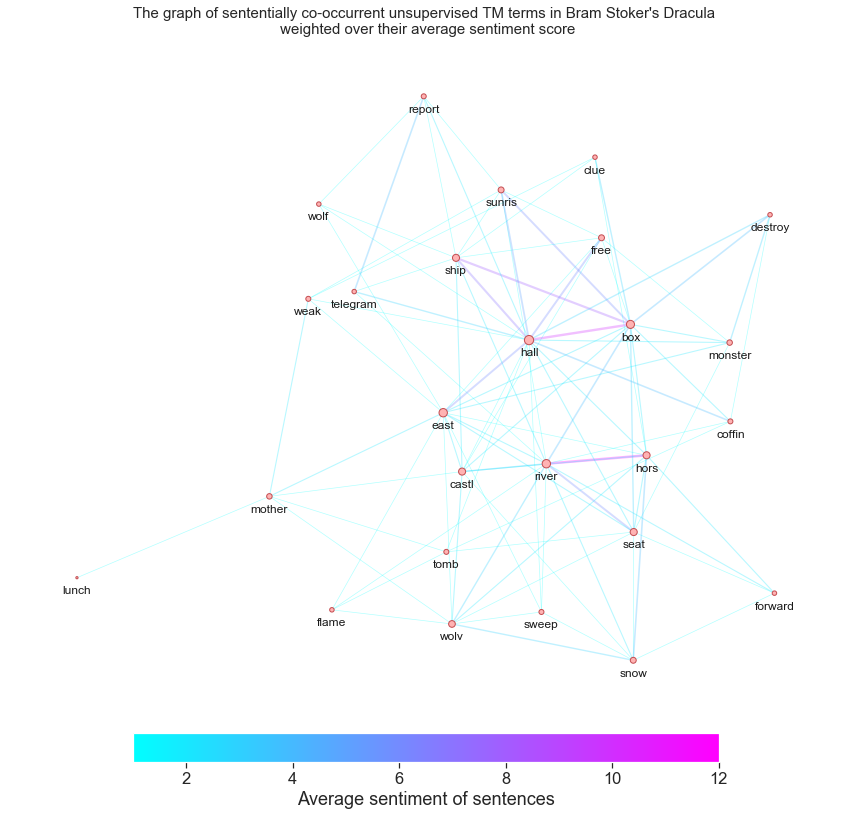

In [26]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[5*Gw.degree(n) for n in Gw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.3)
plt.axis('off');
yoffset = {}
y_off = -5 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gw, yoffset,font_size=12);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of sententially co-occurrent unsupervised TM terms in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

## <span style="color:red">PART C</span>

## 2. Supervized Topic Modeling

### Extraction of Relevant NLP Entities

#### List of NLP Entities

In [27]:
# TYPE          DESCRIPTION
# PERSON        People, including fictional.
# NORP          Nationalities or religious or political groups.
# FAC           Buildings, airports, highways, bridges, etc.
# ORG           Companies, agencies, institutions, etc.
# GPE           Countries, cities, states.
# LOC           Non-GPE locations, mountain ranges, bodies of water.
# PRODUCT       Objects, vehicles, foods, etc. (Not services.)
# EVENT         Named hurricanes, battles, wars, sports events, etc.
# WORK_OF_ART   Titles of books, songs, etc.
# LAW           Named documents made into laws.
# LANGUAGE      Any named language.
# DATE          Absolute or relative dates or periods.
# TIME          Times smaller than a day.
# PERCENT       Percentage, including ”%“.
# MONEY         Monetary values, including unit.
# QUANTITY      Measurements, as of weight or distance.
# ORDINAL       “first”, “second”, etc.
# CARDINAL      Numerals that do not fall under another type.

In [28]:
p = inflect.engine()
d_tags = {}

for key, value in docs_d.items():
    arr = []
    doc = nlp(value.replace('\n',''))
    #Keep these types of nlp entities
    keep_l = ['PERSON','NORP','GPE','LOC','EVENT']
    #Typo/model error + german corrections
    drop_t = []
    
    #Things inflect library handles poorly or to exclude from touching
    ex_ls = []
    
    for X in doc.ents:
        s1 = X.text
        if (X.label_ in keep_l) and (s1.lower() not in drop_t) and (s1):
            arr.append((s1, X.label_))
    d_tags[key] = arr
# pprint(d_tags)
names=[]
for k,v in d_tags.items():
    for vv in v:
        if vv[0] not in names:
            p=vv[0].replace("'","")
            p=p.title()
            names.append(p)
tdocs=" ".join(docs)
names=[n for n in names if n in tdocs]
names=sorted(set(names))
print(len(names))
names

389


['Abraham Van Helsing',
 'Africa',
 'Agatha',
 'America',
 'American',
 'Americanism',
 'Amsterdam',
 'Andres',
 'Andrew Woodhouse',
 'Angel',
 'Antwerp',
 'Archibald',
 'Archimedes',
 'Arminius',
 'Arminus',
 'Arpad',
 'Arsk',
 'Art',
 'Arthur',
 'Arthur Holmwood',
 'Asia',
 'Attila',
 'Austrian',
 'Berkeley',
 'Bermondsey',
 'Bersicker',
 'Bethnal Green',
 'Bilder',
 'Billington',
 'Bistritz',
 'Bistritza',
 'Black Sea',
 'Black-Sea',
 'Bloxam',
 'Borgo',
 'Borgo Prund',
 'Bosphorus',
 'Breakfast',
 'British',
 'Broads',
 'Bucharest',
 'Bukovina',
 'Bulgar',
 'Byron',
 'Cape Matapan',
 'Carpathian',
 'Carpathians',
 'Carter',
 'Carter Paterson',
 'Casabiancaand',
 'Cassova',
 'Castle Dracula',
 'Catherine',
 'Charcot',
 'Charcotalas',
 'Chernosese',
 'China',
 'Christian',
 'Conquistadores',
 'Consulate',
 'Countin',
 'Crescent',
 'Crucifix',
 'Cszeks',
 'Czarina Catherine',
 'D.',
 'D. Lit',
 'D. Ph',
 'Dacians',
 'Danes',
 'Danube',
 'Dardanelles',
 'Deil',
 'Demeter',
 'Denn',
 'D

In [29]:
rem=[]
# for p in names:
#     if "_" in p:
#         rem.append(p)
#     if "--" in p:
#         rem.append(p)
# #     if p not in text:
# #         rem.append(p)
# names=[p for p in names if p not in rem]
pp=[q for q in itertools.product(names,names) if q[0]!=q[1]]
for q in pp:
    if q[0] in q[1]:
        rem.append(q[0])
    if q[1] in q[0]:
        rem.append(q[1])
    w=q[0]+" "+q[1]
    if w in text:
        names.append(w)
        rem.append(q[0])
        rem.append(q[1])
names=[p for p in names if p not in rem]
names=sorted(set(names))
print(len(names))
names

305


['Abraham Van Helsing',
 'Africa',
 'Agatha',
 'Americanism',
 'Amsterdam',
 'Andres',
 'Andrew Woodhouse',
 'Angel',
 'Antwerp',
 'Archibald',
 'Archimedes',
 'Arminius',
 'Arminus',
 'Arpad',
 'Arsk',
 'Arthur Holmwood',
 'Asia',
 'Attila',
 'Austrian',
 'Berkeley',
 'Bermondsey',
 'Bersicker',
 'Bethnal Green',
 'Bistritza',
 'Black Sea',
 'Black-Sea',
 'Borgo Prund',
 'Bosphorus',
 'Breakfast',
 'British',
 'Broads',
 'Bucharest',
 'Bukovina',
 'Bulgar',
 'Byron',
 'Cape Matapan',
 'Carpathians',
 'Carter Paterson',
 'Casabiancaand',
 'Cassova',
 'Castle Dracula',
 'Charcotalas',
 'Chernosese',
 'China',
 'Christian',
 'Conquistadores',
 'Consulate',
 'Countin',
 'Crescent',
 'Crucifix',
 'Cszeks',
 'D. Lit',
 'D. Ph',
 'Dacians',
 'Danes',
 'Danube',
 'Dardanelles',
 'Deil',
 'Demeter',
 'Denn',
 'Derby',
 'Desdemona',
 'Devils',
 'Diary Hillingham',
 'Disraeli',
 'Donelson',
 'Doolittle',
 'Dover',
 'Down',
 'Dr. Seward',
 'Draculas',
 'Dun',
 'Durham',
 'Dutchmanand',
 'East Cli

In [30]:
rem=["Nay","Pass","Ye","Lordship","Friend Arthur","Friend John","Robin","Sister"]
names=[p for p in names if p not in rem]
names=names+['Robin Hood','Soho','Braithwaite Lowrey',
            'Mitchell, Sons, & Candy','Jonathan','Mina','Sister Agatha',
            'Count Dracula','Ste. Mary','St. Joseph',"Saxon"]
names=sorted(set(names))
print(len(names))
names

310


['Abraham Van Helsing',
 'Africa',
 'Agatha',
 'Americanism',
 'Amsterdam',
 'Andres',
 'Andrew Woodhouse',
 'Angel',
 'Antwerp',
 'Archibald',
 'Archimedes',
 'Arminius',
 'Arminus',
 'Arpad',
 'Arsk',
 'Arthur Holmwood',
 'Asia',
 'Attila',
 'Austrian',
 'Berkeley',
 'Bermondsey',
 'Bersicker',
 'Bethnal Green',
 'Bistritza',
 'Black Sea',
 'Black-Sea',
 'Borgo Prund',
 'Bosphorus',
 'Braithwaite Lowrey',
 'Breakfast',
 'British',
 'Broads',
 'Bucharest',
 'Bukovina',
 'Bulgar',
 'Byron',
 'Cape Matapan',
 'Carpathians',
 'Carter Paterson',
 'Casabiancaand',
 'Cassova',
 'Castle Dracula',
 'Charcotalas',
 'Chernosese',
 'China',
 'Christian',
 'Conquistadores',
 'Consulate',
 'Count Dracula',
 'Countin',
 'Crescent',
 'Crucifix',
 'Cszeks',
 'D. Lit',
 'D. Ph',
 'Dacians',
 'Danes',
 'Danube',
 'Dardanelles',
 'Deil',
 'Demeter',
 'Denn',
 'Derby',
 'Desdemona',
 'Devils',
 'Diary Hillingham',
 'Disraeli',
 'Donelson',
 'Doolittle',
 'Dover',
 'Down',
 'Dr. Seward',
 'Draculas',
 'Du

In [31]:
terms_list=[]
for doc in docs:
    t=[]
    for i in names: 
        if i in doc:
            m=doc.count(i)
            t.append(m*[i])
    flatten = sum(t, [])
    terms_list.append(flatten)
print(len(terms_list))
terms_list

27


[['Attila',
  'Borgo Prund',
  'British',
  'Bukovina',
  'Bukovina',
  'Bukovina',
  'Bukovina',
  'Bukovina',
  'Bukovina',
  'Carpathians',
  'Carpathians',
  'Carpathians',
  'Carpathians',
  'Carpathians',
  'Carpathians',
  'Castle Dracula',
  'China',
  'Count Dracula',
  'Count Dracula',
  'Count Dracula',
  'Cszeks',
  'Cszeks',
  'Dacians',
  'Danube',
  'Denn',
  'English',
  'English',
  'English',
  'English',
  'France',
  'Germany',
  'Golden Mediasch',
  'Huns',
  'Huns',
  'Jonathan',
  'Jonathan Harker',
  'Klausenburgh',
  'Lenore',
  'London',
  'London',
  'London',
  'Magyars',
  'Magyars',
  'Mina',
  'Mina',
  'Mina',
  'Moldavia',
  'Munich',
  'Oriental',
  'Saxon',
  'Saxons',
  'Slovaks',
  'Slovaks',
  'Slovaks',
  'South',
  'Todten',
  'Turkish',
  'Vienna'],
 ['Austrian',
  'Carpathians',
  'Count Dracula',
  'Count Dracula',
  'England',
  'England',
  'England',
  'England',
  'England',
  'English',
  'English',
  'English',
  'English',
  'English',


In [32]:
dictionary = gensim.corpora.Dictionary(terms_list)
print(len(dictionary)) #All 32368
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

310
0 Attila
1 Borgo Prund
2 British
3 Bukovina
4 Carpathians
5 Castle Dracula
6 China
7 Count Dracula
8 Cszeks
9 Dacians
10 Danube


In [33]:
# dictionary.filter_extremes(no_below=1, no_above=0.7, keep_n=300)
# len(dictionary) 

In [34]:
bow_corpus = [dictionary.doc2bow(doc) for doc in terms_list]
# bow_corpus[43]

#### <span style="color:red">The minimum number of topics below (mint) should be at least 2 or 3.</span>

In [35]:
# mint = 2  # minimum number of topics
# maxt = 11 # maximum number of topics
# m=30
# X = range(mint,maxt)
# Y = []
# for n in X:
#     ft=[]
#     for j in range(m):
#         lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n, id2word=dictionary, passes=2, workers=2)
#     #     topics = lda_model.print_topics()
#         sss=[]
#         for idx, topic in lda_model.print_topics(-1):
#             tt=[]
#             s=topic.split(" + ")
#             ss=[]
#             uu=[]
#             for t in s:
#                 u0=float(t.split("*")[0])
#                 u1=t.split("*")[1].replace('"','')
#                 if (u1,u0) not in ss:
#                     ss.append((u1,u0))
#                 if t not in uu:
#                     uu.append(t) 
#             sss.append(ss)
#             topic=" + ".join(uu).encode('utf-8')
#         doms=[]
#         for i in sss:
#             doms.append(i[0][0])
#         fi=len(set(doms))/n
#         ft.append(fi)
#     fis=sum(ft)/m
#     Y.append(fis)
# # print(list(X))
# print(Y)
# nn=[]
# for i,y in enumerate(Y):
#     if y==max(Y): #1:
#         print(Y.index(y))
#         nn.append(i)
# print(nn)
# NT=nn[-1]+mint
# print(NT)

In [36]:
NT=3 #number_of_topics
nt=NT 
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=nt, id2word=dictionary, passes=2, workers=2)

In [37]:
topics = lda_model.print_topics() #350 #num_words=100

sterms=[]
lt=[]
for i in range(nt):
    for t in topics: 
        lt.append(t[1].split(" + "))
for s in lt:
    for ss in s:
        sterms.append(ss[6:])
#         if re.sub(r'[^a-zA-Z]','', ss) not in sterms:
#             sterms.append(re.sub(r'[^a-zA-Z]','', ss))
sterms=[t.replace('"',"") for t in sterms]
sterms=sorted(set(sterms))
print(len(sterms))
print(" ")
print("LIST OF SUPERVISED TM TERMS:")
print(" ")
for i in sterms:
    print(i)

15
 
LIST OF SUPERVISED TM TERMS:
 
Dr. Seward
East Cliff
English
Exeter
Galatz
Jonathan
Jonathan Harker
London
Lord Godalming
Lucy Westenra
Mina
Mina Harker
Piccadilly
Quincey Morris
Varna


In [38]:
sss=[]
for idx, topic in lda_model.print_topics(-1):
    tt=[]
    s=topic.split(" + ")
    ss=[]
    uu=[]
    for t in s:
        u0=float(t.split("*")[0])
        u1=t.split("*")[1].replace('"','')
        if (u1,u0) not in ss:
            ss.append((u1,u0))
        if t not in uu:
            uu.append(t) 
    sss.append(ss)
    topic=" + ".join(uu).encode('utf-8')
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: b'0.166*"Jonathan" + 0.104*"Mina" + 0.040*"London" + 0.035*"Dr. Seward" + 0.029*"Lord Godalming" + 0.016*"Galatz" + 0.013*"Mina Harker" + 0.013*"East Cliff" + 0.012*"Varna" + 0.011*"Exeter"'
Topic: 1 
Words: b'0.139*"Dr. Seward" + 0.111*"Jonathan" + 0.055*"Mina" + 0.047*"Lord Godalming" + 0.026*"Quincey Morris" + 0.021*"Mina Harker" + 0.021*"London" + 0.011*"Lucy Westenra" + 0.011*"Jonathan Harker" + 0.009*"Exeter"'
Topic: 2 
Words: b'0.183*"Mina" + 0.054*"Jonathan" + 0.044*"London" + 0.043*"Lord Godalming" + 0.037*"Dr. Seward" + 0.028*"Piccadilly" + 0.021*"Varna" + 0.018*"Quincey Morris" + 0.017*"English" + 0.015*"Jonathan Harker"'


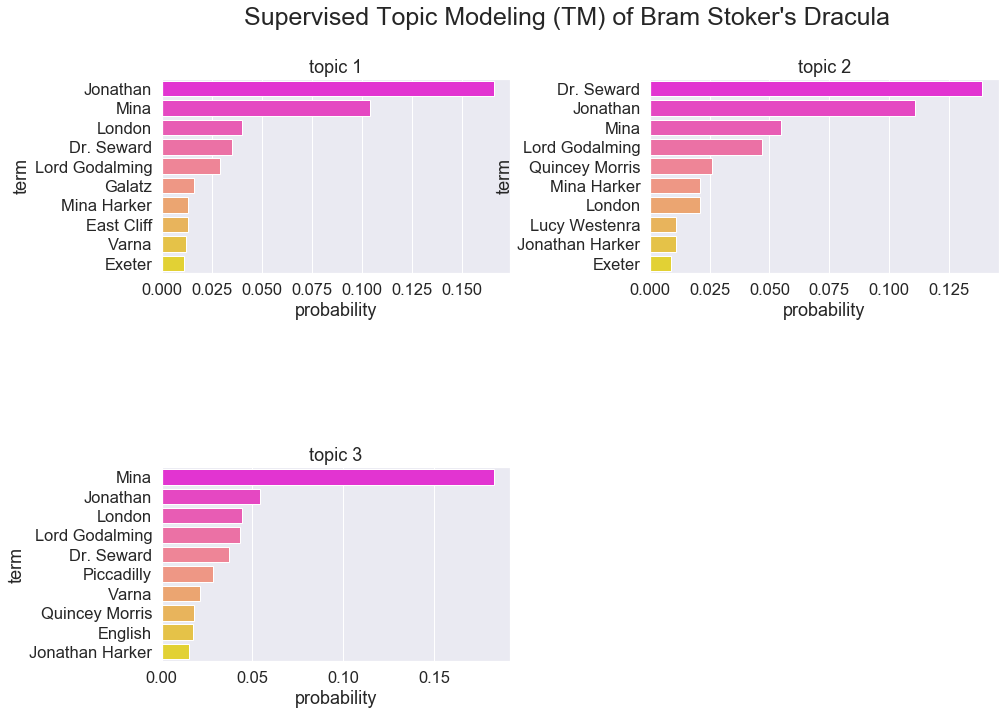

In [39]:
fig=plt.figure(figsize=(15,25)) #figsize=(15,2.4*15*((nt+1)/4))); #15
fig.subplots_adjust(hspace=1, wspace=0.4)
for i in range(nt):
    sns.set(font_scale = 1.5)
    df=pd.DataFrame(sss[i], columns=['term','prob']).set_index('term')
    ax = fig.add_subplot(nt+1,2,i+1)
#     plt.subplot(nt+1,2,i+1); #5
    plt.title('topic '+str(i+1));
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='spring');
    plt.xlabel('probability');
sst="Supervised Topic Modeling (TM) of %s" %titlename
plt.suptitle(sst,fontsize=25, y=0.92);
plt.show()

In [40]:
from pyLDAvis import gensim as pgensim
vis = pgensim.prepare(lda_model,bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.078982 -0.000531       1        1  43.545864
0      0.040050 -0.056095       2        1  42.135178
1      0.038933  0.056627       3        1  14.318959, topic_info=               Term        Freq       Total Category  logprob  loglift
78       Dr. Seward   74.000000   74.000000  Default  30.0000  30.0000
17         Jonathan  159.000000  159.000000  Default  29.0000  29.0000
109  Lord Godalming   55.000000   55.000000  Default  28.0000  28.0000
190  Quincey Morris   19.000000   19.000000  Default  27.0000  27.0000
159     Mina Harker   15.000000   15.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
2           British    0.908674    4.033022   Topic3  -5.4384   0.4533
187       Mein Gott    0.898444    3.178463   Topic3  -5.4497   0.6801
68           Turkey    0.916163    5.747877   Topic3  -5.4302   0.1072
70            Varna    0.936746   21.194391   Topic3  -5.4079  -1.1755
120         Demeter    0.889983    3.180912   Topic3  -5.4592   0.6699

[184 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
152       2  0.892558  Abraham Van Helsing
140       2  0.947766               Agatha
225       3  0.679103          Americanism
153       1  0.347234            Amsterdam
153       2  0.520852            Amsterdam
...     ...       ...                  ...
308       2  0.786722              Veresti
220       1  0.894630              Vincent
242       3  0.677661      Voivode Dracula
243       3  0.675979              Windham
258       1  0.804054                  Yus

[193 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## <span style="color:red">PART D</span>

## The Network of Sententially Co-Occurrent Terms Derived from Supervised Topic Modeling

In [41]:
sterms

['Dr. Seward',
 'East Cliff',
 'English',
 'Exeter',
 'Galatz',
 'Jonathan',
 'Jonathan Harker',
 'London',
 'Lord Godalming',
 'Lucy Westenra',
 'Mina',
 'Mina Harker',
 'Piccadilly',
 'Quincey Morris',
 'Varna']

In [42]:
pre=[]
for i in range(len(sterms)):
    start=sterms[i][:4]
    pre.append(start)
for j,k in Counter(pre).items():
    if k>1:
        print(j)

Jona
Mina


In [43]:
salias_dict={}
for n in sterms:
    if n=="Mina":
        salias_dict[n]="Mina"
    elif n=="Mina Harker":
        salias_dict[n]="Mina"
    elif n=="Jonathan":
        salias_dict[n]="Jonathan"
    elif n=="Jonathan Harker":
        salias_dict[n]="Jonathan"
#     elif n=="Mina Murray":
#         salias_dict[n]="Mina"
#     elif n=="English":
#         salias_dict[n]="England"
#     elif n=="England":
#         salias_dict[n]="England"
#     elif n=="Mitchell, Sons, & Candy":
#         salias_dict[n]="Mitchell"
#     elif n=="Mitchell":
#         salias_dict[n]="Mitchell"
#     elif n=="Quincey Morris":
#         salias_dict[n]="Quincey Morris"
#     elif n=="Quincey P. Morris":
#         salias_dict[n]="Quincey Morris"
#     elif n=="Saxon":
#         salias_dict[n]="Saxon"
#     elif n=="Saxons":
#         salias_dict[n]="Saxon"
#     elif n=="Turkey":
#         salias_dict[n]="Turkey"
#     elif n=="Turkish":
#         salias_dict[n]="Turkey"
#     elif n=="Agatha":
#         salias_dict[n]="Sister Agatha"
#     elif n=="Sister Agatha":
#         salias_dict[n]="Sister Agatha"
    else:
        salias_dict[n]=n
print("The dictionary of aliases has %i keys (terms) and %i unique values (aliased terms)" %(len(salias_dict.keys()),len(set(salias_dict.values()))))
# for k,v in alias_dict.items():
#     print(k,"-->",v)

The dictionary of aliases has 15 keys (terms) and 13 unique values (aliased terms)


In [44]:
tdocs=" ".join(docs)
blob = TextBlob(tdocs)
textSentences = blob.sentences
sendic=dict()
for i,v in enumerate(textSentences):
    sent=v.sentiment.polarity
    wl=[]
    for term in list(set(salias_dict.values())):
        if term in v: 
            wl.append(term)
    if len(wl)>1:
        sendic[i]=wl 
smedges=[]
for k,v in sendic.items():
    sent=textSentences[k].sentiment.polarity
    dd={}
    ps=set()
    for j in itertools.combinations(v, 2):
        ps.add(j)
        dd[j]=(k,sent)
    for jj in ps:
        s=0
        ss=0
        for kk,vv in dd.items():
            if kk==jj:
                s+=1
                ss+=vv[1]
        if salias_dict[jj[0]]!=salias_dict[jj[1]]:
            smedges.append((salias_dict[jj[0]],salias_dict[jj[1]],"Sentence_"+str(k),ss/float(s)))
print("%s contains %i sentential co-occurrences among %i supervized TM terms"%(titlename,len(smedges),len(set(salias_dict.values()))))
smedges

Bram Stoker's Dracula contains 74 sentential co-occurrences among 13 supervized TM terms


[('London', 'Exeter', 'Sentence_358', 0.13636363636363635),
 ('London', 'Exeter', 'Sentence_422', 0.03969155844155844),
 ('London', 'Exeter', 'Sentence_552', 0.5499999999999999),
 ('London', 'Varna', 'Sentence_585', 0.0),
 ('Mina', 'Lucy Westenra', 'Sentence_1039', 0.0),
 ('Mina', 'Lucy Westenra', 'Sentence_1066', 0.0),
 ('Mina', 'Lucy Westenra', 'Sentence_1112', 0.0),
 ('Mina', 'Lucy Westenra', 'Sentence_2153', 0.0),
 ('Mina', 'Lucy Westenra', 'Sentence_2210', 0.0),
 ('Mina', 'Lucy Westenra', 'Sentence_2279', 0.07222222222222223),
 ('Mina', 'Lucy Westenra', 'Sentence_3389', 0.0),
 ('Mina', 'Lucy Westenra', 'Sentence_3457', 0.0),
 ('London', 'Exeter', 'Sentence_3776', 0.05),
 ('Jonathan', 'Exeter', 'Sentence_3999', 0.1486111111111111),
 ('Mina', 'Lucy Westenra', 'Sentence_4013', -0.4),
 ('Jonathan', 'Exeter', 'Sentence_4109', 0.1),
 ('Jonathan', 'London', 'Sentence_5010', 0.0),
 ('Jonathan', 'Dr. Seward', 'Sentence_5018', 0.0),
 ('Exeter', 'Dr. Seward', 'Sentence_5018', 0.0),
 ('Jonath

In [45]:
smedgesd=[]
for e in smedges:
    d={}
    d['Sentence']=e[2]
    d['Average sentiment']=e[3]
    smedgesd.append((e[0],e[1],d))
    
sG = nx.MultiGraph()
sG.add_edges_from(smedgesd)
for e in sG.edges(data=True):
    if e[0]==e[1]:
        sG.remove_edge(e[0],e[1])
weight={(x,y):v for (x, y), v in Counter(sG.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
sGw = nx.Graph()
sGw.add_weighted_edges_from(w_edges)

print("The graph of sententially co-occurrent supervised TM terms in %s is a weighted graph and \n it has %i nodes and %i edges \n" %(titlename,len(sGw.nodes()),len(sGw.edges())))
out=' '.join([n+"\n" for n in salias_dict.values() if n not in sGw.nodes()])
print("The terms which do not co-occur in sentences are: \n %s" %out)
# print "Graph sGw is a weighted graph with %i nodes and %i edges" %(len(sGw.nodes()),len(sGw.edges()))
print("The density of this graph is %.3f" %nx.density(sGw))
if nx.is_connected(sGw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(sGw),"connected components" )   
    giant = max(connected_component_subgraphs(sGw), key=len)
    sGwlcc=sGw.subgraph(giant)
    print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(sGwlcc.nodes()),len(sGwlcc.edges())))
    print ("The density of the largest connected component of this graph is %.3f" %nx.density(sGwlcc))

The graph of sententially co-occurrent supervised TM terms in Bram Stoker's Dracula is a weighted graph and 
 it has 11 nodes and 24 edges 

The terms which do not co-occur in sentences are: 
 East Cliff
 English

The density of this graph is 0.436
This graph is a connected graph


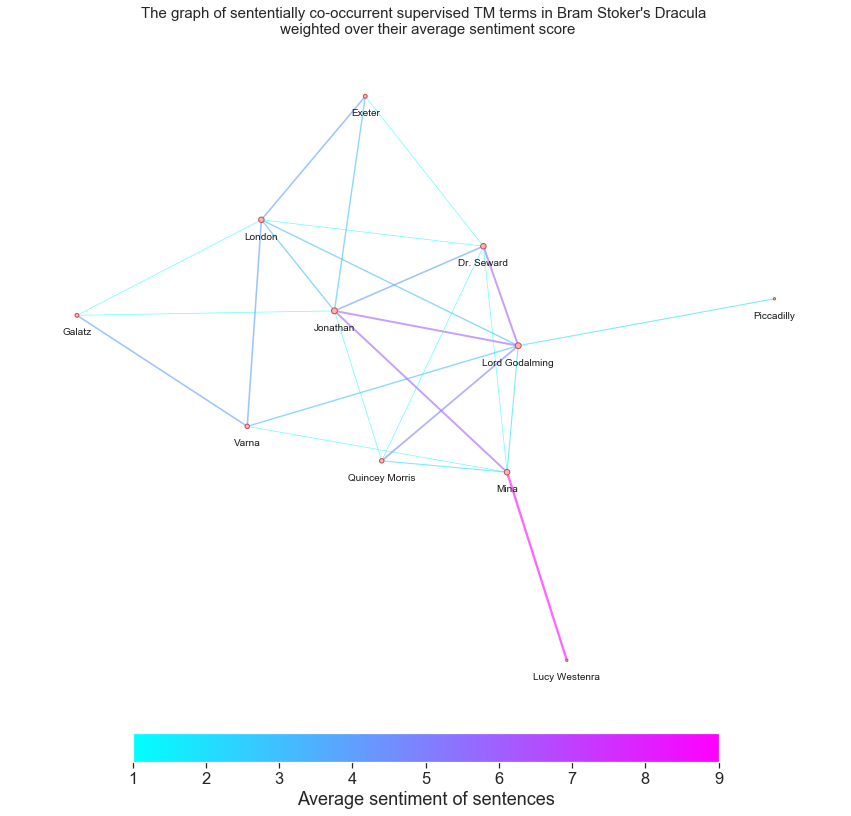

In [46]:
edge_width=[sGw[u][v]['weight'] for u,v in sGw.edges()]
edge_width=[math.log(1+w) for w in edge_width]
cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in sGw.edges(data=True) ]
edge_color=weight_list
vmin = min(edge_color) 
vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[5*sGw.degree(n) for n in sGw.nodes()]

figsize=(15,15)

pos=graphviz_layout(sGw) 
# pos=nx.spring_layout(sGw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(sGw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(sGw, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.6)
plt.axis('off');
yoffset = {}
y_off = -7 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(sGw, yoffset,font_size=10);
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
cbar.set_label('Average sentiment of sentences')
sst="The graph of sententially co-occurrent supervised TM terms in %s \n weighted over their average sentiment score" %titlename
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

In [47]:
# # Run this is the graph is NOT connected 

# sorted(sGwlcc.nodes())

In [48]:
# # Run this is the graph is NOT connected 

# edge_width=[sGwlcc[u][v]['weight'] for u,v in sGwlcc.edges()]
# edge_width=[math.log(1+w) for w in edge_width]
# cmap=plt.cm.cool
# weight_list = [ e[2]['weight'] for e in sGwlcc.edges(data=True) ]
# edge_color=weight_list
# vmin = min(edge_color) 
# vmax = max(edge_color) 
# # width_list=[2*math.log(2+w) for w in weight_list]
# width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
# nsi=[5*sGwlcc.degree(n) for n in sGwlcc.nodes()]

# figsize=(15,15)

# pos=graphviz_layout(sGwlcc) 
# # pos=nx.spring_layout(sGw)

# # pos['Samuel F. Billington']=(382.22, 550)
# # pos['Amsterdam']=(398.54, 522)
# # pos['Switzerland']=(200, 507.22)
# # pos['Peter Hawkins']=(321.72, 514)
# # pos['Danube']=(290, 390)
# # pos['Windham']=(358.32, 270)
# # pos['Mile']=(230.97, 350)
# # pos['Black Sea']=(290.5, 420)
# # pos['Bosphorus']=(361.57, 540)
# # pos['Yorkshire']=(347.89, 500)


# node_color="#ffb3b3"
# node_border_color="r"
# plt.figure(figsize=figsize);
# nodes = nx.draw_networkx_nodes(sGwlcc, pos, node_color=node_color,node_size=nsi)
# nodes.set_edgecolor(node_border_color)
# nx.draw_networkx_edges(sGwlcc, pos, edge_color=edge_color,edge_cmap=cmap,vmin=vmin, vmax=vmax,width=edge_width,alpha=0.6)
# plt.axis('off');
# yoffset = {}
# y_off = -7 # offset on the y axis
# for k, v in pos.items():
#     yoffset[k] = (v[0], v[1]+y_off)
# nx.draw_networkx_labels(sGwlcc, yoffset,font_size=12);
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
# cbar.set_label('Average sentiment of sentences')
# sst="The largest connected component of the \n graph of sententially co-occurrent supervised TM terms in %s \n weighted over their average sentiment score" %titlename
# plt.title(sst,fontsize=15);
# plt.margins(x=0.1, y=0.1) 

In [49]:
print("Run in %.2f seconds (%.2f minutes)" %(time.clock() - start_time,(time.clock() - start_time)/60))

Run in 64.32 seconds (1.07 minutes)
